In [1]:
'''
Husayn El Sharif
Rainfed Cotton Yield Prediction (Southern Georgia Region) using Monthly Weather Data

Note: Including CO2 data did NOT improve model performance
Note: Increasing epoch size from 500 to 1500 did improve performance
Note: Using Bidirectional LSTM BiLSTM seems to improve performance even if epoch size is 500

Settle on using BiLSTM and epoch size 1000
'''

'\nHusayn El Sharif\nRainfed Cotton Yield Prediction (Southern Georgia Region) using Monthly Weather Data\n\nNote: Including CO2 data did NOT improve model performance\nNote: Increasing epoch size from 500 to 1500 did improve performance\nNote: Using Bidirectional LSTM BiLSTM seems to improve performance even if epoch size is 500\n'

In [2]:
# import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense, Bidirectional

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import joblib

from sklearn.metrics import mean_squared_error # Import mean_squared_error from sklearn.metrics
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error


2025-01-07 07:42:22.880672: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 07:42:22.889769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736253742.900241  751758 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736253742.903282  751758 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 07:42:22.914220: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
crop_name = 'cotton'

In [4]:
# Import Crop Model Data

crop_model_data_path = '02 Crop Model Results Agg Spreadsheets (Monthly)/{}_rainfed.xlsx'.format(crop_name)

imported_df_dictionary = pd.read_excel(crop_model_data_path, sheet_name = None)
sheet_names = list(imported_df_dictionary.keys()) # create a list of the sheet names

In [5]:
# Aggregate X (climate) and y data (yield)
# note: skip data from Years 1982 and 1985

X_list = [] # initialize
y_list = [] # initialize

for s in sheet_names:
    current_df = imported_df_dictionary[s]
    current_year = current_df['Year'].iloc[0]
    if current_year != 1982 and current_year != 1985:
        X_excerpt = current_df[['SRAD', 'TMAX', 'TMIN', 'TAVG', 'PRE']]
        y_excerpt = current_df[['YIELD']].iloc[0]
        X_list.append(X_excerpt)
        y_list.append(y_excerpt)

# convert to numpy arrays
X_data = np.array(X_list)
y_data = np.array(y_list)
        

In [6]:
# Samples, features, and targets
num_samples = X_data.shape[0]
num_features = X_data.shape[1]
num_targets = y_data.shape[1]

In [7]:
# Fit scalers
input_scaler = MinMaxScaler() # initialize
input_scaler = input_scaler.fit(pd.concat(X_list, axis=0))

output_scaler =  MinMaxScaler() # initialize
output_scaler = output_scaler.fit(pd.DataFrame(y_data))


In [8]:
# scale data
X_data_scaled_df = pd.DataFrame(input_scaler.transform(pd.concat(X_list, axis=0)), columns=['SRAD', 'TMAX', 'TMIN', 'TAVG', 'PRE'] )
y_data_scaled_df = pd.DataFrame(output_scaler.transform(pd.DataFrame(y_data)), columns=['YIELD'] )

In [9]:
# split scaled data into samples. Every 16 rows is a sample

In [10]:
X_data_scaled_list = []
y_data_scaled_list = []

rows_per_sample = 7
for r in range(0, len(X_data_scaled_df), rows_per_sample):
    X_excerpt = X_data_scaled_df.iloc[r:r+rows_per_sample].values
    X_data_scaled_list.append(X_excerpt)

for r in range(0, len(y_data_scaled_df)):
    y_excerpt = y_data_scaled_df.iloc[r].values
    y_data_scaled_list.append(y_excerpt)

In [11]:
# convert to numpy arrays for LSTM
X_data_scaled_array = np.array(X_data_scaled_list)
y_data_scaled_array = np.array(y_data_scaled_list)

In [12]:
# Split X_data_scaled_array and y_data_scaled_array into Train (80%, 280 samples), Validation (10%, 35 samples), and Test (10%, 35 smaples) data
X_data_scaled_array_shuffled, y_data_scaled_array_shuffled = shuffle(X_data_scaled_array, y_data_scaled_array, random_state=12232)


In [13]:
# Split into Train, Val, Test
X_train = X_data_scaled_array_shuffled[0:280]
X_val = X_data_scaled_array_shuffled[280:280+35]
X_test = X_data_scaled_array_shuffled[280+35:280+35+35]

y_train = y_data_scaled_array_shuffled[0:280]
y_val = y_data_scaled_array_shuffled[280:280+35]
y_test = y_data_scaled_array_shuffled[280+35:280+35+35]

In [14]:
X_train.shape

(280, 7, 5)

In [15]:
# Build Model

LSTM_Model = Sequential() # initialize

# input layer
LSTM_Model.add(
    Input(
        shape=(X_train.shape[1], X_train.shape[2]) # shape = (number of time steps within a sample, number of features)
    ))

# Hidden Layer 1, with dropout regulariation layer, return sequences
LSTM_Model.add( Bidirectional( LSTM(units=80, return_sequences = True) ) )
LSTM_Model.add(Dropout(0.2))

# Hidden Layer 2, with dropout regulariation layer, return sequences
LSTM_Model.add( Bidirectional( LSTM(units=80, return_sequences = True) ) )
LSTM_Model.add(Dropout(0.2))


# Hidden Layer 3, with dropout regulariation layer, do not return sequences
LSTM_Model.add( Bidirectional( LSTM(units=80, return_sequences = False) ) )
LSTM_Model.add(Dropout(0.2))

# Final Layer, Dense/Output Layer
LSTM_Model.add( Dense(units=1) )

# Compile model
LSTM_Model.compile( optimizer = "adam", loss = "mean_squared_error")

I0000 00:00:1736253745.271638  751758 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5566 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [16]:
# Train Model

model_location = "models_monthly/"
model_name = "lstm_rainfed_{}_yield.model.keras".format(crop_name)
best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name, 
    monitor="val_loss", 
    save_best_only=True, 
    mode="min", 
    verbose=0)

history = LSTM_Model.fit(
    x = X_train, 
    y = y_train, 
    epochs= 1000, 
    validation_data=(X_val, y_val),
    batch_size = 30, 
    callbacks = [best_model_checkpoint_callback])

Epoch 1/1500


I0000 00:00:1736253748.089459  751852 cuda_dnn.cc:529] Loaded cuDNN version 90300


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.1486 - val_loss: 0.0422
Epoch 2/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0435 - val_loss: 0.0404
Epoch 3/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0395 - val_loss: 0.0316
Epoch 4/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0345 - val_loss: 0.0258
Epoch 5/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0306 - val_loss: 0.0232
Epoch 6/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0289 - val_loss: 0.0214
Epoch 7/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0283 - val_loss: 0.0195
Epoch 8/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0250 - val_loss: 0.0229
Epoch 9/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0270 - val_loss: 0.0210
Epoch 10/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0285 - val_loss: 0.0197
Epoch 11/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0223 - val_loss: 0.0237
Epoch 12/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 

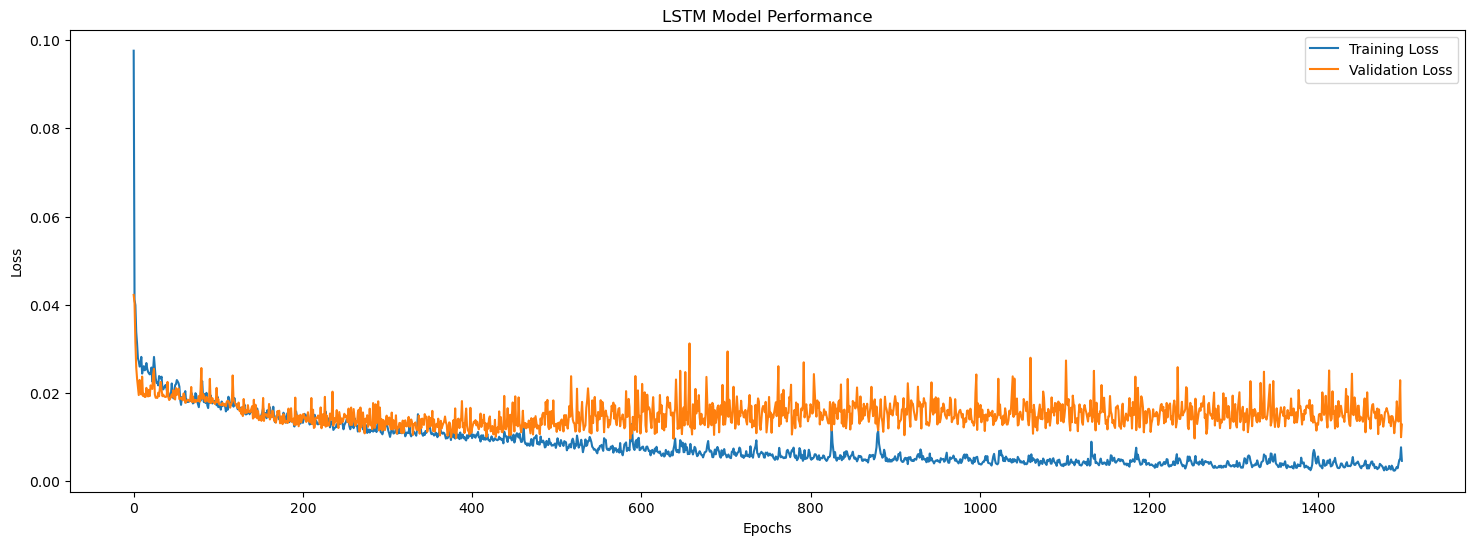

In [17]:
# Visualize Model Performance During Training

plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
# Load Best Model
best_model = load_model(model_location + model_name)

In [19]:
# Model Prediction
# Predict crop yield for all data splits (scaled results)
y_train_predict = best_model.predict(X_train)
y_val_predict = best_model.predict(X_val)
y_test_predict = best_model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [20]:
# reverse scaling
y_train_inv = output_scaler.inverse_transform(y_train)
y_val_inv = output_scaler.inverse_transform(y_val)
y_test_inv = output_scaler.inverse_transform(y_test)

y_train_predict_inv = output_scaler.inverse_transform(y_train_predict)
y_val_predict_inv = output_scaler.inverse_transform(y_val_predict)
y_test_predict_inv = output_scaler.inverse_transform(y_test_predict)

Text(0.5, 1.0, 'Crop Yield')

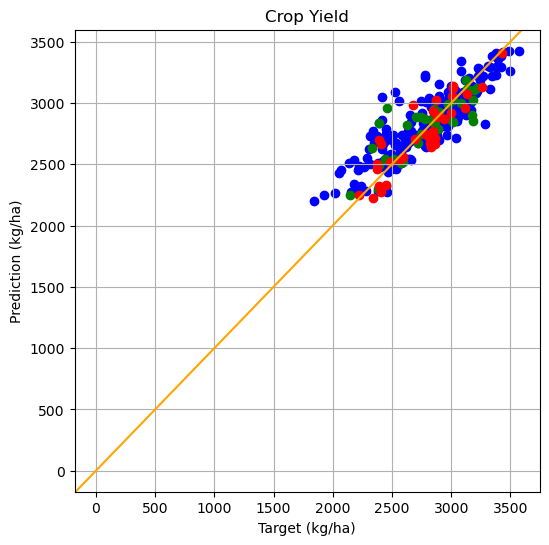

In [21]:
# plot results as scatter
plt.figure(figsize=(6,6))

# train (blue)
plt.scatter(x=y_train_inv, y=y_train_predict_inv, c='blue')

# val (green)
plt.scatter(x=y_val_inv, y=y_val_predict_inv, c='green')

# test (red)
plt.scatter(x=y_test_inv, y=y_test_predict_inv, c='red')

plt.grid(visible=True, which='major', axis='both')
plt.axline([0, 0], [1, 1], c='orange')
plt.xlabel('Target (kg/ha)')
plt.ylabel('Prediction (kg/ha)')
plt.title('Crop Yield')


Text(0.5, 1.0, 'Crop Yield (Training)')

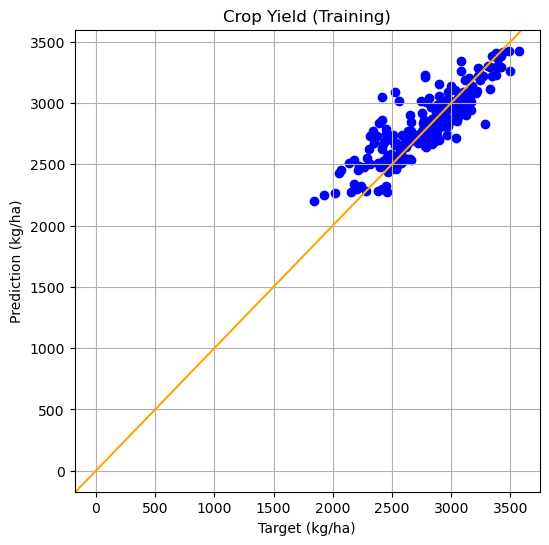

In [22]:
# Training Scatter Plot

# plot results as scatter
plt.figure(figsize=(6,6))

# train (blue)
plt.scatter(x=y_train_inv, y=y_train_predict_inv, c='blue')

plt.grid(visible=True, which='major', axis='both')
plt.axline([0, 0], [1, 1], c='orange')

plt.xlabel('Target (kg/ha)')
plt.ylabel('Prediction (kg/ha)')
plt.title('Crop Yield (Training)')

Text(0.5, 1.0, 'Crop Yield (Validation)')

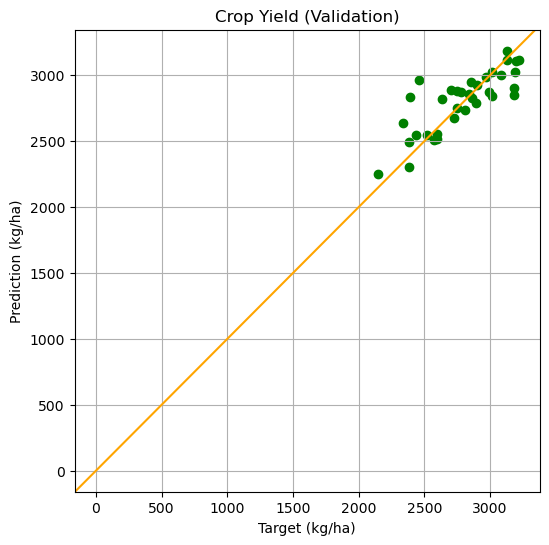

In [23]:
# Validation Scatter Plot
# plot results as scatter
plt.figure(figsize=(6,6))


# val (green)
plt.scatter(x=y_val_inv, y=y_val_predict_inv, c='green')


plt.grid(visible=True, which='major', axis='both')
plt.axline([0, 0], [1, 1], c='orange')

plt.xlabel('Target (kg/ha)')
plt.ylabel('Prediction (kg/ha)')
plt.title('Crop Yield (Validation)')

Text(0.5, 1.0, 'Crop Yield (Testing)')

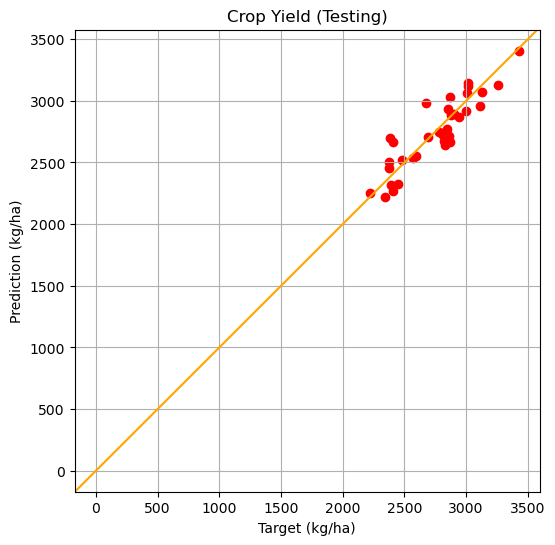

In [24]:
# Testing Scatter Plot

# plot results as scatter
plt.figure(figsize=(6,6))

# test (red)
plt.scatter(x=y_test_inv, y=y_test_predict_inv, c='red')

plt.grid(visible=True, which='major', axis='both')
plt.axline([0, 0], [1, 1], c='orange')

plt.xlabel('Target (kg/ha)')
plt.ylabel('Prediction (kg/ha)')
plt.title('Crop Yield (Testing)')

In [25]:
# Performance Metrics: Train

rmse = root_mean_squared_error(y_train_inv, y_train_predict_inv)
r2 = r2_score(y_train_inv, y_train_predict_inv)
mae = mean_absolute_error(y_train_inv, y_train_predict_inv)

print('RMSE: {:.2f} kg/ha '.format(rmse))
print('MAE: {:.2f} kg/ha'.format(mae))
print('R2: {:.2f}'.format(r2))

RMSE: 157.07 kg/ha 
MAE: 112.09 kg/ha
R2: 0.74


In [26]:
# Performance Metrics: Validation

rmse = root_mean_squared_error(y_val_inv, y_val_predict_inv)
r2 = r2_score(y_val_inv, y_val_predict_inv)
mae = mean_absolute_error(y_val_inv, y_val_predict_inv)

print('RMSE: {:.2f} kg/ha '.format(rmse))
print('MAE: {:.2f} kg/ha'.format(mae))
print('R2: {:.2f}'.format(r2))

RMSE: 169.39 kg/ha 
MAE: 122.61 kg/ha
R2: 0.65


In [27]:
# Performance Metrics: Testing

rmse = root_mean_squared_error(y_test_inv, y_test_predict_inv)
r2 = r2_score(y_test_inv, y_test_predict_inv)
mae = mean_absolute_error(y_test_inv, y_test_predict_inv)

print('RMSE: {:.2f} kg/ha '.format(rmse))
print('MAE: {:.2f} kg/ha'.format(mae))
print('R2: {:.2f}'.format(r2))

RMSE: 130.27 kg/ha 
MAE: 105.08 kg/ha
R2: 0.79
